# Explortatory analysis 

Notebook for exploratory analysis on tetrode data in the mPFC of a rat doing the parametric working memory (PWM) task.

Session: `data_sdc_20190902_145404_fromSD`

Current data storage:
* raw .dat, .rec, .mda, .bin and preprocessed .bin files are located on scratch under ``

* sorted data is located on bucket `Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata`

* in a sorted folder: 
    * folder for each .bin bundle & cluster notes, matlab struct w/ spike info from scraped phy, matlab struct w/ behavior info scraped from bdata
    * in .bin bundle folder you will find curated kilosort output, mask info as npy and preprocessed .bin that was run

see [jbreda_PWM_ephys_analysis](https://github.com/Brody-Lab/jbreda_PWM_ephys_analysis) for more info on how this info was obtained


**TODO**
* plotting iterations
* save out bndl dfs as csv?
* create a dict of paths? or determine what should be passed into to bigger script



## Libs & fxs

In [8]:
# libraries
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import pickle
# stored one repo up in my fork of Spykes
from spykes.spykes.plot.neurovis import NeuroVis
from io_utils import *
from plotting_utils import * 

# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## I/O & Wrangle

In [ ]:
"Helpful code for saving out"
# sess_names = np.array(['data_sdb_20190724_193007_fromSD', 'data_sdc_20190902_145404_fromSD', 'W122_07_27_2019_1_fromSD', 
#             'W122_08_06_2019_1_fromSD', 'W122_08_07_2019_1_fromSD', 'W122_08_31_2019_1_fromSD', 'W122_09_04_2019_1_fromSD',
#             'W122_09_09_2019_1_fromSD', 'W122_09_10_2019_1_fromSD', 'W122_09_11_2019_1_fromSD', 'W122_09_12_2019_1_fromSD',
#             'W122_09_19_2019_1_fromSD', 'W122_09_21_2019_1_fromSD', 'W122_09_24_2019_1_fromSD'])

analyze_sess = np.array(['data_sdc_20190902_145404_fromSD', 'W122_08_06_2019_1_fromSD', 'W122_08_07_2019_1_fromSD', 'W122_08_31_2019_1_fromSD', 'W122_09_04_2019_1_fromSD', 'W122_09_09_2019_1_fromSD', 'W122_09_12_2019_1_fromSD', 'W122_09_21_2019_1_fromSD'])

#np.save('sess_names.npy', sess_names)


# # beh_df.to_csv(os.path.join(dir_name, sess_name, 'beh_df.csv'), index=False)

# # preloading spks_dict
# import pickle

# f = open(os.path.join(dir_name, sess_name, 'spks_dict.pkl'),"wb")
# pickle.dump(spks_dict,f)
# f.close()

# f= open(os.path.join(dir_name, sess_name, 'spks_dict.pkl'), "rb")
# loaded_dictionary = pickle.load(f)

# fig_dir = os.path.join(os.getcwd(), 'figures', 'neurovis')
# os.mkdir(os.path.join(fig_dir, sess_name))
# fig_save_dir = os.path.join(fig_dir, sess_name)

In [9]:
# base paths/names
sess_names = np.load('sess_names.npy')
sess_name = sess_names[1]

base_path  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'


# create paths
sess_path = os.path.join(base_path, sess_name)
beh_path  = os.path.join(sess_path, beh_mat)
spks_path = os.path.join(sess_path, spks_mat)
fig_save_path = os.path.join(os.getcwd(), 'figures', 'neurovis', sess_name)

# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=True)


C:\Users\brodylab\Documents\GitHub\jbreda_PWM_ephys_analysis\io_utils.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh_df['hit_hist'][beh_df['hit_hist'].isnull()] = "viol"


In [23]:
spks_dict

{'date': '190902',
 'spk2fsm': array([  0.99994683, 130.6813586 ]),
 'fs': 30000,
 'trode_nums': [8, 10, 10, 10],
 'spk_qual': ['multi', 'multi', 'multi', 'multi'],
 'spk_times': [array([[ 630.68913607],
         [ 630.71466805],
         [ 630.73770016],
         ...,
         [5305.27491967],
         [5305.28535244],
         [5305.30828456]]),
  array([[ 630.80926302],
         [ 630.90905771],
         [ 630.91409078],
         ...,
         [5304.87194109],
         [5304.88334049],
         [5304.93253787]]),
  array([[ 630.85672716],
         [ 631.12857937],
         [ 635.01620597],
         ...,
         [5300.12316029],
         [5300.13319309],
         [5300.59860167]]),
  array([[ 630.66323745],
         [ 630.68966938],
         [ 630.72376757],
         ...,
         [5305.36471489],
         [5305.37978076],
         [5305.39241342]])],
 'mean_wav': [array([[-29.86769634, -26.33201295, -16.77566434,  -1.70596231,
           15.81754689,  31.30769942,  41.29871659,  44

# Plotting 2 second, Hit trials

In [22]:
if os.path.exists(os.path.join(sess_path, 'mask_dict.pkl')):
    with open(os.path.join(sess_path, 'mask_dict.pkl'), 'rb') as fh:
        mask_dict = pickle.load(fh)

In [61]:
# filter dataframe
beh_df_d2_h = beh_df[(beh_df['delay'] == 2)
       & (beh_df['hit_hist'] == 'hit')]

# deal with masking
bndl_dfs, df_names = deal_with_masking(spks_dict, beh_df_d2_h, sess_path)

Creating mask_dict...
loading mask info....
mask info loaded
loading mask info....
mask info loaded
ngood, first: 31
ngood, second: 27
ngood, second: 27
ngood, second: 27


In [57]:
len(beh_df_d2_h)

116

In [56]:
n = 3
neuro_test = NeuroVis(spks_dict['spk_times'][n], name = "neuron4jb")


'bndl2_df'

In [11]:
# initilaize
events = ['c_poke', 'aud1_on', 'aud2_on', 'aud1_on']
windows = [[-300,700], [-500,1000], [-500, 500], [-1000,2300]]
condition = 'correct_side'

# get neurons into NeuroVis objects
neurons = initiate_neurons(spks_dict)

# create
neuron_rasters = get_neuron_rasters(neurons, events, windows, bndl_dfs, df_names)
neuron_psths = get_neuron_psths(neurons, events, windows, bndl_dfs, df_names, conditions=condition)

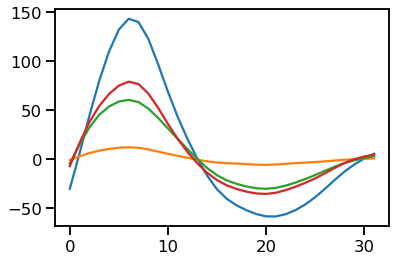

In [25]:
mean_wav = spks_dict['mean_wav'][1]
for tt in range(4):
    plt.plot(mean_wav[tt])

In [12]:
# iteratively plot
sns.set_context("talk")

# iterate over neurons
for nn in range(len(neurons)):
    
    # grab mean waveform for the neuron
    mean_wav = spks_dict['mean_wav'][nn]
  
    # iterate over event
    for ee in range(len(events)):
        
        # initilaize plot
        fig = plt.figure(figsize=(18,12))
        ax1 = plt.subplot2grid((4, 3), (0, 0), rowspan=2, colspan=2) 
        ax2 = plt.subplot2grid((4, 3), (2, 0), rowspan=2, colspan=2)
        ax3 = plt.subplot2grid((4, 3), (1, 2), rowspan=2, colspan=1)
       
        # plot raster and psth for each neuron, event
        neurons[nn].plot_raster(neuron_rasters[nn][ee], axis = ax1, event_name=events[ee], cmap="Greys")
        neurons[nn].plot_psth(neuron_psths[nn][ee],axis=ax2, event_name=events[ee])
        
        # plot average waveform from active tetrode
        for tt in range(4):
            
            ax3.plot(mean_wav[tt])
            ax3.set_title('Average Waveform')
    
        fig_name = "{sess}_neuron_{neuron}_{event}_{ee}".format(sess = sess_name, 
                                                                neuron = nn, event = events[ee],
                                                               ee = ee)
        # format & save out
        plt.tight_layout()
        plt.savefig(os.path.join(fig_save_path, fig_name))
        plt.close("all")


In [ ]:
"""TODO- iteratvely plot final plot(raster, psth, avg wav) for all 4 nuerons in all 4 conditions & save out"""
"""TODO- then, put into .py scrip, adjust top inputs, and run on good days from august"""

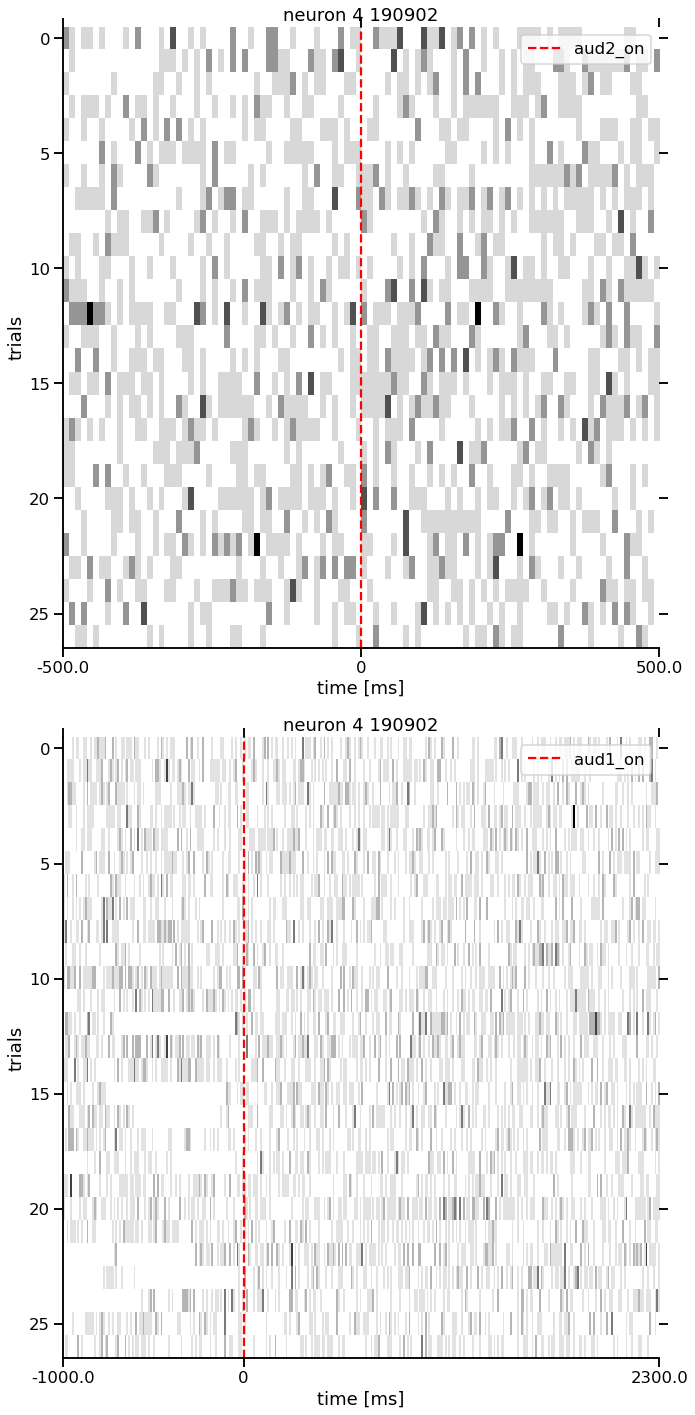

In [27]:
fig, ax = plt.subplots(2,1, figsize = (10,20))
nn = 3
cc = 2
neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax[0], event_name=events[cc], cmap="Greys")
neurons[nn].plot_raster(neuron_rasters[nn][cc+1], axis = ax[1], event_name=events[cc+1], cmap="Greys")

# neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax[1], event_name=events[cc])

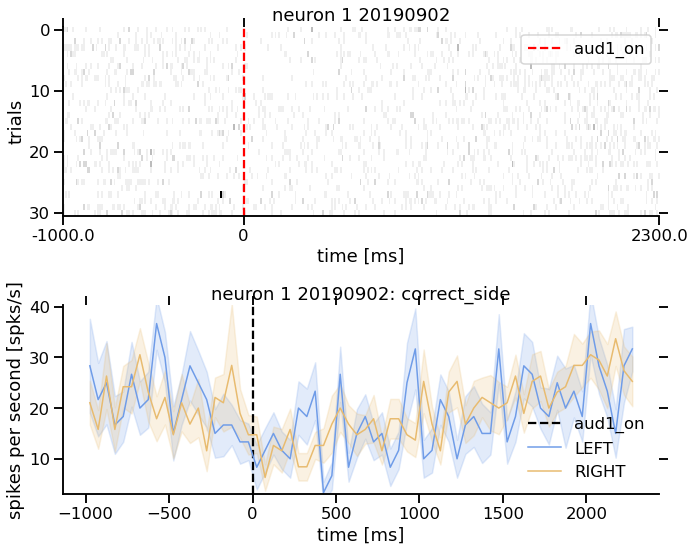

In [40]:
fig, ax = plt.subplots(2,1, figsize = (10,8))
nn = 0
cc = 3

neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax[0], event_name=events[cc], cmap="Greys")
neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax[1], event_name=events[cc])

## Rogue plots

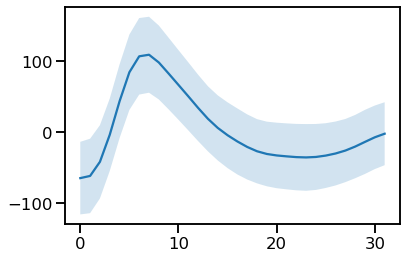

In [25]:
nn = 0
tt = 1
mean_wave = spks_dict['mean_wav'][nn][tt].T
std = spks_dict['std_wave'][nn][tt].T
plt.plot(mean_wave)
plt.fill_between(np.arange(len(std)), mean_wave + std, mean_wave - std, alpha = 0.2)

In [24]:
spks_dict['std_wave'][1][0].

(32,)

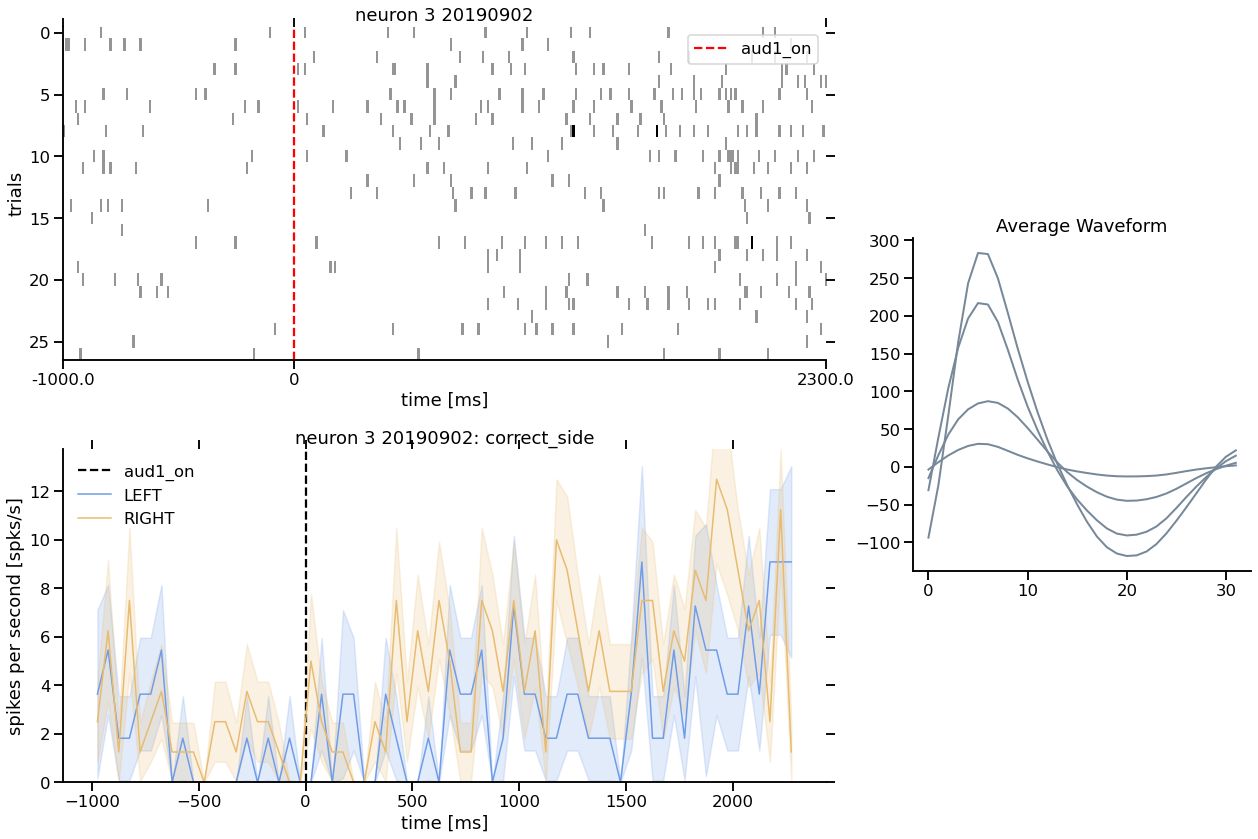

In [44]:
sns.set_context("talk")
fig = plt.figure(figsize=(18,12))
ax1 = plt.subplot2grid((4, 3), (0, 0), rowspan=2, colspan=2) 
ax2 = plt.subplot2grid((4, 3), (2, 0), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((4, 3), (1, 2), rowspan=2, colspan=1)


nn = 2
cc = 3

mean_wav = spks_dict['mean_wav'][nn]


neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax1, event_name=events[cc], cmap="Greys")
neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax2, event_name=events[cc])
for i in range(4):
    ax3.plot(mean_wav[i],color = 'lightslategrey',lw=2)
    
ax3.set_title('Average Waveform')

save_name=neurons[0].name
fig.savefig('neuron1.jpeg')
